**Timothy Ng - COVID-19 Detection Report: Advanced Machine Learning Projects**

**Introduction**

The dataset used in this project comes from  M.E.H. Chowdhury Et al., “Can AI help in screening Viral and COVID-19 pneumonia?” (2020), which can be found here https://arxiv.org/abs/2003.13145. It consists of digital chest x-ray images for those diagnosed with COVID-19, those who are not sick, and those diagnosed with viral pneumonia. The aim of that paper was to utilise pre-trained machine learning algorithims to accuratley classify different chest x-ray images into their respective categories. This project will operate in a similar vein, attempting to transform the data, and implement a variety of machine learning approaches to see if we can improve on the researchers original methodology. You can find more about this project on my Github: https://github.com/timnyt/COVID-19-Image-Classification

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset.zip

In [7]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [8]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-3466.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3417.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2734.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-609.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1777.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2337.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3405.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1656.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-672.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2587.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3274.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2790.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-683.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2815.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-460.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [9]:
#Reduce number of images to first 1345 for each category for memory purposes
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [10]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [11]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [12]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [13]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each diagnosis type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


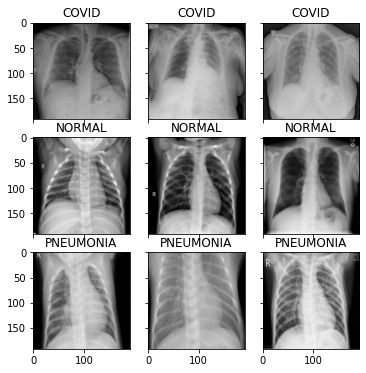

In [14]:
#display images of each diagnosis

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][1])
im2 =preprocessor(fnames[0][2])
im3 =preprocessor(fnames[0][5])
im4 =preprocessor(fnames[1][1])
im5 =preprocessor(fnames[1][2])
im6 =preprocessor(fnames[1][3])
im7 =preprocessor(fnames[2][1])
im8 =preprocessor(fnames[2][2])
im9 =preprocessor(fnames[2][3])

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )
#Add labels
labels = ['COVID', 'COVID', 'COVID', "NORMAL", "NORMAL", "NORMAL", "PNEUMONIA", "PNEUMONIA", "PNEUMONIA"]
label = 0
for axes in grid:
    axes.set_title(labels[label], fontdict=None, loc='center', color = "k")
    label +=1

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()



The images above paint a clear picture of the difference between Covid, healthy chest x-ray images, and pneumonia. The images depiciting cases of COVID-19 show x-rays which are very cloudly due to COVID increasing the density of one's lungs. The images of pneumonia are similar, but significantly less opaque while the images of normal lungs show little to no opaqeuness. Being able to quickly classify which image belongs to which category is useful as we would be giving doctors a speedy alternative for diagnosis over the RT-PCR, the standard diagnosis procedure, which is both expensive and time consuming. Therefore, it is certainly worthwhile to build a predictive model using this data. 





**Modeling**

Much of the modelling for this project was done for the purposes of submission to a modelling competeition on [modelshare.org](https://www.modelshare.org/). Here, I will share the code for my three best models, a CNN, an MLP, and a transfer learning model. I found that the transfer learning model worked best for me (90.6% accuracy), followed by the CNN model(89.7 % accuracy), and finally the MLP(85.4% accuracy). During the tuning process I found that removing the dropout layer, removing 4 convolutional layers before each max pooling layer, removing the last pooling layer, and increasing epochs increased the score. I also found that changing to average pooling instead of max, adding strides, and adding a batch normalization layer decreased the scores across the board. 

In [15]:
#set credentials for modelling
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade


In [17]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [18]:
#Train test split resized images
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [14]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [1]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

NameError: ignored

In [4]:
# Reload data whenever RAM is depeted
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

EOFError: ignored

In [17]:
#Model 1 C.N.N

import tensorflow as tf
with tf.device('/device:GPU:0'): 

  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 12, verbose=1,validation_data=(X_test,y_test)) #12 epochs

Epoch 1/12
86/86 [==============================] - 16s 71ms/step - loss: 0.7184 - accuracy: 0.7238 - val_loss: 0.4100 - val_accuracy: 0.8280
Epoch 2/12
86/86 [==============================] - 5s 52ms/step - loss: 0.3830 - accuracy: 0.8395 - val_loss: 0.3827 - val_accuracy: 0.8505
Epoch 3/12
86/86 [==============================] - 5s 58ms/step - loss: 0.2858 - accuracy: 0.8960 - val_loss: 0.3154 - val_accuracy: 0.8745
Epoch 4/12
86/86 [==============================] - 5s 57ms/step - loss: 0.2062 - accuracy: 0.9245 - val_loss: 0.3235 - val_accuracy: 0.8761
Epoch 5/12
86/86 [==============================] - 5s 54ms/step - loss: 0.1615 - accuracy: 0.9409 - val_loss: 0.3050 - val_accuracy: 0.9009
Epoch 6/12
86/86 [==============================] - 5s 54ms/step - loss: 0.1086 - accuracy: 0.9595 - val_loss: 0.3337 - val_accuracy: 0.9009
Epoch 7/12
86/86 [==============================] - 5s 60ms/step - loss: 0.0675 - accuracy: 0.9763 - val_loss: 0.3767 - val_accuracy: 0.9024
Epoch 8/12
8

In [18]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [19]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 19ms/step


In [20]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 412

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
#Model 2 MLP
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Dense(units = 32, activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Dense(units = 32, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model2.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the MLP to the Training set
  model2.fit(X_train, y_train, 
                   epochs = 12, verbose=1, validation_data=(X_test,y_test)) #12 epochs

scores2 = model2.evaluate(X_test, y_test) # extract loss and accuracy from test data evaluation
print("Loss and accuracy score for model 2:", scores2)


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [ ]:
#import libraries for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Input
from tensorflow.keras.models import Model

In [ ]:
#Model 3 Transfer Learning

#Create training/validation iterators
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(192,192,3))

# flatten the output of the convolutional part: 
x = Flatten()(vgg.output)
# three hidden layers
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
# final softmax layer with 3 categories
predictions = Dense(3, activation='softmax')(x)

# creating the final model:
final = Model(inputs=vgg.input, outputs=predictions)
final.summary() #Getting summary of final model

#Lock layers
for layer in vgg.layers:
    layer.trainable = False
#Compile
final.compile(
  optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

#Train Data
final.fit(X_train, y_train)
#Test Data
final.evaluate(X_test, y_test)

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(final, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=final.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

**References**

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145